In [91]:
import matplotlib.pyplot as plt
import numpy as np
import math
from numpy.random import randn
from scipy.linalg import inv

# Kalman Filter

Kalman filter is a bayesian filter used to approximate system state using given measurements and process model. Below I will implement Kalman filter for multivariable system and demonstrate its results. Next step is to improve Kalman filter by implementing dynamic calculation of process noise during filters operation in order to improve its precision

## Research Process Description

In order to show results of the research, following plan was developed:
1. Develop a model with several variables, such as train movement.
2. Create imprecise measurements of the model, in order to use filter on
3. Show performance of a classic Kalman Filter on the model and measurements
4. Design Kalman filter with uses an agent to calculate process and sensor error as the filtering is in process
5. Show differences in performance of the filters - accuracy, speed, memory usage

## Model Under Study

As an example we will use train for which we have a location sensor. We will estimate speed and location as variables for our model.

## Kalman Filter Overview

![kalman](img/kalman-2.png)

In principle kalman filter has two stages prediction and update. During prediction we compute _prior_ which is the estimation of the next state of the system. During update step we incorporate measurements and select value of the system somewhere between prediction and measurement based on _Kalman gain_.

Below we will see how these stages are described and how we implement them.

## Kalman Filter Algorithm

**Initialization**

    1. Initialize the state of the filter
    2. Initialize initial state of the system
    
**Predict**

    1. Use process model to predict state at the next time step
    2. Adjust belief to account for the uncertainty in prediction    
**Update**

    1. Get a measurement and associated belief about its accuracy
    2. Compute residual between estimated state and measurement
    3. Compute scaling factor based on whether the measurement
    or prediction is more accurate
    4. set state between the prediction and measurement based 
    on scaling factor
    5. update belief in the state based on how certain we are 
    in the measurement

## Variables in Kalman Filter

Now let's describe all variables we need for a Kalman filter:

$\mathbf{x}$ - state vector, when we talk about state, we always assume mean value, since we are never sure.

$\mathbf{P}$ - covariance matrix of our state.

$\mathbf{F}$ - state transition function.

$\mathbf{Q}$ - process covariance, this is uncertainty you have about your model calculations.

$\mathbf{B}$ - input function, transformation of an input vector corresponding to a model.

$\mathbf{u}$ - input vector.

$\mathbf{H}$ - measurement function.

$\mathbf{z}$ - measurement mean, basically value we get from the sensor.

$\mathbf{R}$ - measurement covariance matrix, how our measurement can deviate from the real value

$\mathbf{K}$ - Kalman gain, or how much we trust either measurement or prediction

$\mathbf{y}$ - residual

## Equations

Kalman filter is described by the following equations:

### Prediction

$\bar{\mathbf x} = \mathbf{Fx} + \mathbf{Bu}$

$\bar{\mathbf P} = \mathbf{FPF}^\mathsf T + \mathbf Q$

### Update

$\mathbf y = \mathbf z - \mathbf{H\bar x}$

$\mathbf K = \mathbf{\bar{P}H}^\mathsf T (\mathbf{H\bar{P}H}^\mathsf T + \mathbf R)^{-1}$

$ \mathbf x = \bar{\mathbf x} + \mathbf{Ky}$

$\mathbf P = (\mathbf I - \mathbf{KH})\mathbf{\bar{P}}$

## Simulation for testing

For testing purposes we need to generate simulation. In our case it is movement of a train. We need to generate measurement with some deviation, as well as our prediction with some process deviation. We will have length of the simulation as a parameter and make samples every second. System will have initial position in form of a vector - first value is initial coordinate, second is initial speed. Each iteration we will change coordinate by speed + process noise. Also when we take measurements, sensor noise will be added. Function will return two vectors - vector of predicted coordinates and vector of measured coordinates.

In [35]:

def generate_simulation(initial_state, process_var, sensor_var, length=1):
    x = initial_state[0]
    v = initial_state[1]
    
    process_std = math.sqrt(process_var)
    sensor_std = math.sqrt(sensor_var)
    
    coordinates, measurements = [], []
    
    for _ in range(length):
        x += v + randn() * process_std # compute new coordinate
        coordinates.append(x)
        measurements.append(x + randn() * sensor_std) #compute sensor readings
    
    return np.array(coordinates), np.array(measurements)
        

## Visualizing Simulation

Now let's see how results of our simulation look like.

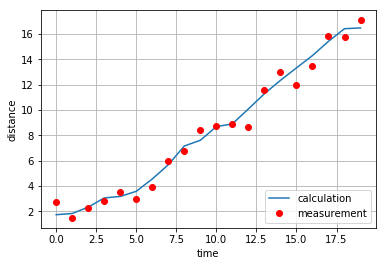

In [83]:
sim_length = 20
x, m = generate_simulation([0, 1], process_var=0.2, sensor_var=0.5, length=sim_length)

plt.plot(range(sim_length), x, label="calculation")
plt.plot(range(sim_length), m ,'ro', label="measurement")
plt.ylabel("distance")
plt.xlabel("time")
plt.legend(loc='lower right', shadow=False)
plt.grid(True)
plt.show()

## Implementation of Kalman Filter

To produce Kalman filter, we need to write two functions - predict and update You will see their code below.

## Predict function

As we already have seen above, prediction function consists of the follwing equations:

$\bar{\mathbf x} = \mathbf{Fx} + \mathbf{Bu}$

$\bar{\mathbf P} = \mathbf{FPF}^\mathsf T + \mathbf Q$

Prediction is used to compute prior - what we _predict_ will be the next state of the system. State of the system consists of mean of its variables and their covariance matrix.

In [82]:
def predict(x, P, F, Q, B=0, u=0):
    nx = np.dot(F, x) + np.dot(B, u)
    nP = np.dot(F, P).dot(F.T) + Q
    return nx, nP

## Update Function

Update function consists of the following equations:

$\mathbf y = \mathbf z - \mathbf{H\bar x}$

$\mathbf K = \mathbf{\bar{P}H}^\mathsf T (\mathbf{H\bar{P}H}^\mathsf T + \mathbf R)^{-1}$

$ \mathbf x = \bar{\mathbf x} + \mathbf{Ky}$

$\mathbf P = (\mathbf I - \mathbf{KH})\mathbf{\bar{P}}$

This function is used to choose middlepoint between our prediction and measurement.

In [93]:
def update(H, P, R, x, z):
    y = z - np.dot(H, x)
    A = inv(np.dot(H, P).dot(H.T) + R)
    K = np.dot(P, H.T).dot(A)
    nx = x + np.dot(K, y)
    nP = P - np.dot(K, H).dot(P)
    
    return nx, nP

## Kalman Filter

Using functions defined above, let's write Kalman Filter.

In [95]:
def kalman(x, P, measures, R, Q, F, H, B=0, u=0):
    xs, Ps = [], []
    for m in measures:
        x, P = predict(x, P, F, Q, B, u)
        x, P = update(H, P, R, x, m)
        xs.append(x)
        Ps.append(P)
    return np.array(xs), np.array(Ps)

    

## Parameters for our example

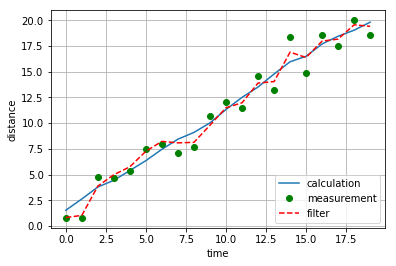

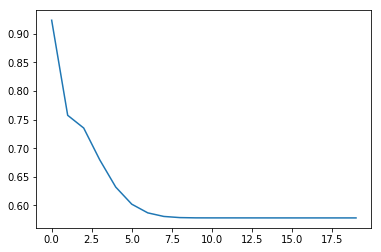

In [146]:
sim_length = 20
x = np.array([[0., 1]]).T
P = np.diag([10., 2.])
F = np.array([[1., 1],
             [0., 1]])
R = np.array([[1.0]])
Q = np.array([[0.1, 0.0],
              [0., 0.1]])
H = np.array([[1., 0]])

xs, m = generate_simulation([0, 1], process_var=0.1, sensor_var=1.0, length=sim_length)

fx, fP = kalman(x, P, m, R, Q, F, H)

plt.plot(range(sim_length), xs, label="calculation")
plt.plot(range(sim_length), m ,'go', label="measurement")
plt.plot(range(sim_length), fx[:, 0], 'r--', label="filter")
plt.ylabel("distance")
plt.xlabel("time")
plt.legend(loc='lower right', shadow=False)
plt.grid(True)
plt.show()

plt.plot(range(sim_length), fP[:, 0, 0])
plt.show()